# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [8]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [9]:
# Extract the training images and labels
X_train = train['X']
y_train = train['y']

# Extract the testing images and labels
X_test = test['X']
y_test = test['y']

In [16]:
X_train.shape[3]

73257

Training data shape: (73257, 32, 32, 3)
Training labels shape: (73257,)
Testing data shape: (26032, 32, 32, 3)
Testing labels shape: (26032,)


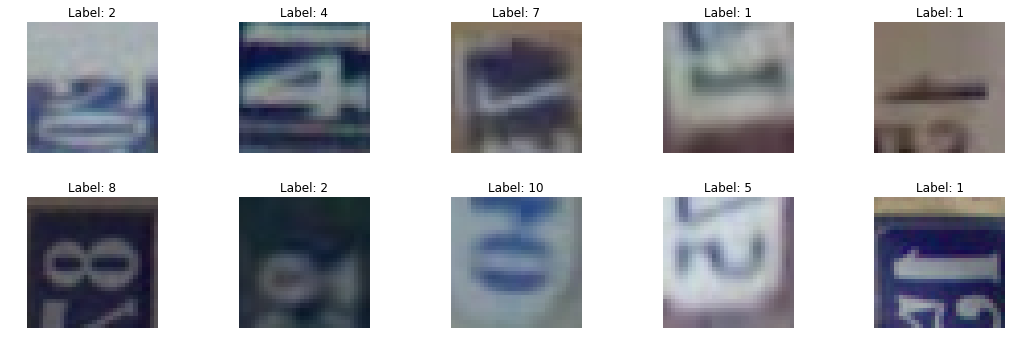

In [17]:
import numpy as np
import matplotlib.pyplot as plt

X_train = X_train.transpose((3, 0, 2, 1))  
X_test = X_test.transpose((3, 0, 2, 1))   # Correct transposition

# Reshape y_train and y_test to be 1-dimensional arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

# Print the shapes to verify
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Ensure we do not select more samples than available
num_samples = 10
available_samples = X_train.shape[0]
if num_samples > available_samples:
    num_samples = available_samples

# Select a random sample of images and their corresponding labels
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
sample_images = X_train[random_indices]
sample_labels = y_train[random_indices]

# Plot the sample images with their corresponding labels
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
X_train_gray = np.mean(X_train, axis=-1, keepdims=True)
X_test_gray = np.mean(X_test, axis=-1, keepdims=True)

y_train -= 1
y_test -= 1

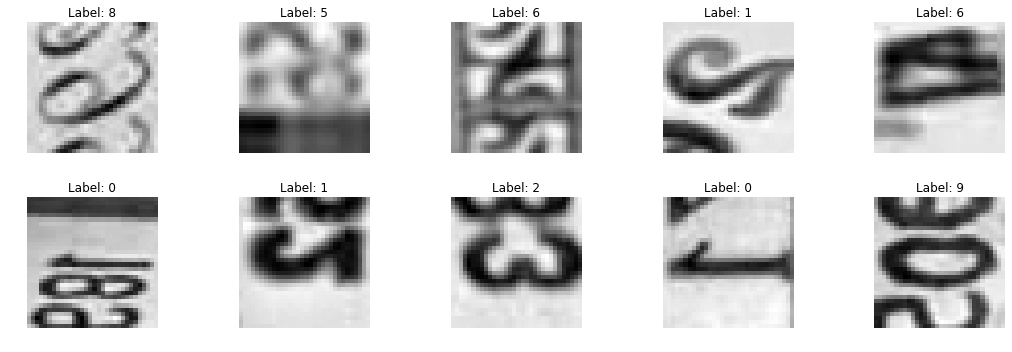

In [19]:
num_samples = 10
available_samples = X_train_gray.shape[0]
if num_samples > available_samples:
    num_samples = available_samples

# Select a random sample of images and their corresponding labels
random_indices = np.random.choice(X_train_gray.shape[0], num_samples, replace=False)
sample_images = X_train_gray[random_indices]
sample_labels = y_train[random_indices]

# Plot the sample images with their corresponding labels
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # Use squeeze to remove the single channel dimension
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [26]:

# Build the model
model = Sequential([
    Flatten(input_shape=(32, 32, 1)),  # Flatten the input
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [32]:
checkpoint = ModelCheckpoint('best_mlp_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

In [33]:
history = model.fit(X_train_gray, y_train, 
                    epochs=30, 
                    validation_split=0.1, 
                    callbacks=[checkpoint, reduce_lr])

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65856/65931 [============================>.] - ETA: 0s - loss: 4.5155 - accuracy: 0.2751
Epoch 00001: val_accuracy improved from -inf to 0.46233, saving model to best_mlp_model.h5
65931/65931 [==============================] - 79s 1ms/sample - loss: 4.5120 - accuracy: 0.2754 - val_loss: 1.6452 - val_accuracy: 0.4623
Epoch 2/30
65856/65931 [============================>.] - ETA: 0s - loss: 1.4719 - accuracy: 0.5277
Epoch 00002: val_accuracy improved from 0.46233 to 0.56129, saving model to best_mlp_model.h5
65931/65931 [==============================] - 75s 1ms/sample - loss: 1.4714 - accuracy: 0.5278 - val_loss: 1.3653 - val_accuracy: 0.5613
Epoch 3/30
65888/65931 [============================>.] - ETA: 0s - loss: 1.3245 - accuracy: 0.5822
Epoch 00003: val_accuracy improved from 0.56129 to 0.65643, saving model to best_mlp_model.h5
65931/65931 [==============================] - 76s 1ms/sample - loss: 1.3244 - accuracy: 0.5823 

Epoch 27/30
65920/65931 [============================>.] - ETA: 0s - loss: 0.7576 - accuracy: 0.7687
Epoch 00027: val_accuracy improved from 0.74720 to 0.75785, saving model to best_mlp_model.h5
65931/65931 [==============================] - 75s 1ms/sample - loss: 0.7577 - accuracy: 0.7687 - val_loss: 0.8153 - val_accuracy: 0.7578
Epoch 28/30
65824/65931 [============================>.] - ETA: 0s - loss: 0.7579 - accuracy: 0.7678
Epoch 00028: val_accuracy did not improve from 0.75785
65931/65931 [==============================] - 74s 1ms/sample - loss: 0.7580 - accuracy: 0.7677 - val_loss: 0.8222 - val_accuracy: 0.7553
Epoch 29/30
65856/65931 [============================>.] - ETA: 0s - loss: 0.7523 - accuracy: 0.7707
Epoch 00029: val_accuracy did not improve from 0.75785
65931/65931 [==============================] - 75s 1ms/sample - loss: 0.7526 - accuracy: 0.7705 - val_loss: 0.8073 - val_accuracy: 0.7529
Epoch 30/30
65888/65931 [============================>.] - ETA: 0s - loss: 0.75

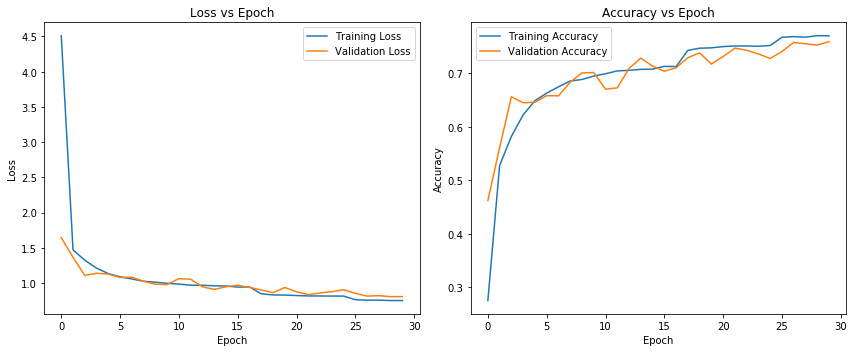

In [34]:
# Plot the learning curves
plt.figure(figsize=(12, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_gray, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.9593
Test Accuracy: 0.7321


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [22]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [29]:
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

In [30]:
history = model.fit(X_train_gray, y_train, 
                     epochs=10,
                    batch_size=64,
                    validation_split=0.1, 
                    callbacks=[checkpoint, reduce_lr])

Train on 65931 samples, validate on 7326 samples
Epoch 1/10
65920/65931 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8613
Epoch 00001: val_accuracy improved from -inf to 0.89681, saving model to best_cnn_model.h5
65931/65931 [==============================] - 703s 11ms/sample - loss: 0.4526 - accuracy: 0.8613 - val_loss: 0.3525 - val_accuracy: 0.8968
Epoch 2/10
65920/65931 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.8630
Epoch 00002: val_accuracy improved from 0.89681 to 0.90513, saving model to best_cnn_model.h5
65931/65931 [==============================] - 694s 11ms/sample - loss: 0.4454 - accuracy: 0.8629 - val_loss: 0.3394 - val_accuracy: 0.9051
Epoch 3/10
65920/65931 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8686
Epoch 00003: val_accuracy improved from 0.90513 to 0.90745, saving model to best_cnn_model.h5
65931/65931 [==============================] - 692s 10ms/sample - loss: 0.4313 - accuracy: 0

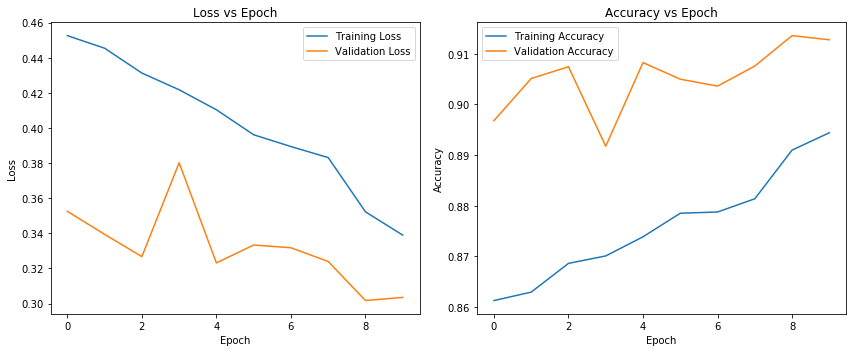

In [31]:
# Plot the learning curves
plt.figure(figsize=(12, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_gray, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.3401
Test Accuracy: 0.9083


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [36]:
best_mlp_model = load_model('best_mlp_model.h5')
best_mlp_model.load_weights('best_mlp_model.h5')

best_cnn_model = load_model('best_cnn_model.h5')
best_cnn_model.load_weights('best_cnn_model.h5')

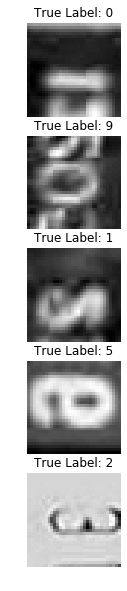

In [37]:
num_samples = 5
random_indices = np.random.choice(X_test_gray.shape[0], num_samples, replace=False)
sample_images = X_test_gray[random_indices]
sample_labels = y_test[random_indices]

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f"True Label: {sample_labels[i]}")
    plt.axis('off')

Text(0, 0.5, 'Probability')

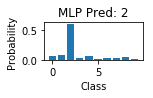

In [38]:
    # MLP predictions
    mlp_pred = best_mlp_model.predict(np.expand_dims(sample_images[i], axis=0))
    mlp_pred_label = np.argmax(mlp_pred)
    
    plt.subplot(5, 3, 3*i + 2)
    plt.bar(range(10), mlp_pred[0])
    plt.title(f"MLP Pred: {mlp_pred_label}")
    plt.xlabel('Class')
    plt.ylabel('Probability')
    

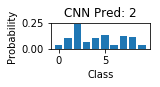

In [40]:
    # CNN predictions
    cnn_pred = best_cnn_model.predict(np.expand_dims(sample_images[i], axis=0))
    cnn_pred_label = np.argmax(cnn_pred)
    
    plt.subplot(5, 3, 3*i + 3)
    plt.bar(range(10), cnn_pred[0])
    plt.title(f"CNN Pred: {cnn_pred_label}")
    plt.xlabel('Class')
    plt.ylabel('Probability')

plt.tight_layout()
plt.show()

In [41]:
# Evaluate the MLP model on the test set
mlp_test_loss, mlp_test_accuracy = best_mlp_model.evaluate(X_test_gray, y_test)
print(f"MLP Test Loss: {mlp_test_loss:.4f}")
print(f"MLP Test Accuracy: {mlp_test_accuracy:.4f}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

MLP Test Loss: 0.4033
MLP Test Accuracy: 0.8853


In [42]:
# Evaluate the CNN model on the test set
cnn_test_loss, cnn_test_accuracy = best_cnn_model.evaluate(X_test_gray, y_test)
print(f"CNN Test Loss: {cnn_test_loss:.4f}")
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

CNN Test Loss: 0.3463
CNN Test Accuracy: 0.9065
